In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

import torchvision
import matplotlib.pyplot as plt
#Affichage barre d'avancement
from tqdm.notebook import tqdm
import numpy as np

In [16]:
#Taille de batch apprentissage et Inférence
batch_size_train = 64 # We use a small batch size here for training
batch_size_test = 1024 #

# Transforme l'image en tensor et normalise les couleurs
# Le résultat sera stocké dans le dossier "processed"
# https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Normalize

image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize( # input[channel] - mean[channel]) / std[channel]
        (0.1307,), # moyenne pour la normalisation (1 seul channel car N&B)
        (0.3081,)  # écart type pour la normalisation (1 seul channel car N&B)
    )
])
#image datasets (prédéfini dans torchvision)

train_dataset = torchvision.datasets.FashionMNIST('dataset/',
                                                  train=True,
                                                  download=True,
                                                  transform=image_transform)
test_dataset = torchvision.datasets.FashionMNIST('dataset/',
                                                 train=False,
                                                 download=True,
                                                 transform=image_transform)
# dataloaders (parcours intelligent des exemples)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test,
                                          shuffle=True)
libelle_label = {0:'T-shirt/top',1:'Pantalon',2:'Pull-over',3:'Robe',4:'Manteau',5:'Sandale',6:'Chemise',7:'Espadrilles',8:'Sac',9:'Botte'}

In [17]:
print(f"train : {len(train_dataset)} images.")
print(f"test : {len(test_dataset)} images.")

train : 60000 images.
test : 10000 images.


torch.Size([1024, 1, 28, 28]) / torch.Size([1024])


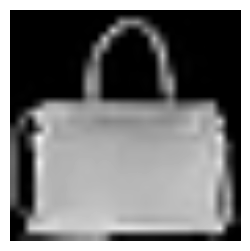

Label: Sac


In [18]:
_, (example_datas, labels) = next(enumerate(test_loader))
print(example_datas.shape, '/',labels.shape)
# Affichage du premier exemple du batch
sample = example_datas[0][0]
#denormalisation
sample = (sample * 0.3081) + 0.1307
fig = plt.figure(figsize=(3,3))
plt.axis('off')
plt.imshow(sample, cmap='gray', interpolation='bilinear')
plt.show()
print("Label: "+ libelle_label[labels[0].item()])

In [19]:
class CNN(nn.Module):
    def __init__(self,drop_prob=0.1):
        super(CNN, self).__init__()
        # Première couche de convolution
        self.conv1 = nn.Conv2d( # Padding par défaut = 0
            1,                  # Input channel (1 car N&B)
            10,                 # Output channel (nombre de noyau de filtre)
            kernel_size=5,      # Taille du noyau de filtre 5 x 5
            stride=1            # pas du parcours
        )
        #pooling 2D
        self.pool1 = nn.MaxPool2d(2) # polling par matrice 2x2
        # Deuxième couche de convolution
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=1)
        #dropout layer
        self.conv2_drop = nn.Dropout2d(drop_prob) # Dropout au niveau d'un channel complet
        #pool 2D
        self.pool2 = nn.MaxPool2d(2)
        # Couches denses
        self.fc1 = nn.Linear(20 * 4 * 4, 50)  # features 1D x taille première couche
        self.fc2 = nn.Linear(50, 10)          # Taille première couche * nb classes
        self.drop = nn.Dropout(drop_prob)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = self.pool2(x)
        x = F.relu(x)
        # Garde nombre de batchs et applatit le reste
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.drop(x)
        x = self.fc2(x)
        # Applique log à softmax pour pénaliser d'avantage les erreurs
        # https://pytorch.org/docs/master/generated/torch.nn.LogSoftmax.html?highlight=logsoftmax#torch.nn.LogSoftmax
        # Permet de travailler avec la log probability
        # https://en.wikipedia.org/wiki/Log_probability
        return F.log_softmax(x,dim=1)


In [20]:
## create model and optimizer
learning_rate = 0.01
momentum = 0.5
# Choix cpu  ou gpu
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
    print('%d GPU(s) available' % torch.cuda.device_count())
model = CNN().to(device)
# D'autres algorithmes de Gradient descent sont possibles
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
summary(model, (1, 28, 28))


1 GPU(s) available
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
         MaxPool2d-2           [-1, 10, 12, 12]               0
            Conv2d-3             [-1, 20, 8, 8]           5,020
         Dropout2d-4             [-1, 20, 8, 8]               0
         MaxPool2d-5             [-1, 20, 4, 4]               0
            Linear-6                   [-1, 50]          16,050
           Dropout-7                   [-1, 50]               0
            Linear-8                   [-1, 10]             510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.08
Estimated Total Size (MB): 0.16
----------------------------------------------------------------


In [21]:
##Fonction d'apprentissage
def train(model, device, train_loader, optimizer, epoch, log_interval=10000):
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    counter = 0
    for batch_idx, (data, target) in enumerate(tk0):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        # Fonction de log vraisemblance
        # https://fr.wikipedia.org/wiki/Fonction_de_vraisemblance#Log-vraisemblance
        # Se combine avec fonction log_softmax dans la création du modèle
        # https://pytorch.org/docs/master/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss        #
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        counter += 1
        tk0.set_postfix(loss=(loss.item()*data.size(0) / (counter * train_loader.batch_size)))


In [22]:
##Fonction de test
def test(model, device, test_loader):
    model.eval() # Désactive le Dropout
    test_loss = 0
    correct = 0
    with torch.no_grad(): # n'intervient pas sur le computation graph (pas d'action sur le gradient)
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target).item() # Fonction de coût (somme des classes)
            pred = output.argmax(dim=1) # Prédiction
            correct += pred.eq(target).sum().item() # Nbre de prévision corrects
    test_loss /= len(test_loader.dataset)

    print('\nTest set: coût : {:.4f}, Précision: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [23]:
num_epoch = 3
for epoch in range(1, num_epoch + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)



Test set: coût : 0.0005, Précision: 8171/10000 (81.71%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: coût : 0.0005, Précision: 8303/10000 (83.03%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: coût : 0.0006, Précision: 7813/10000 (78.13%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: coût : 0.0005, Précision: 8158/10000 (81.58%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: coût : 0.0004, Précision: 8417/10000 (84.17%)



In [24]:
test(model, device, test_loader)



Test set: coût : 0.0005, Précision: 8303/10000 (83.03%)


Test set: coût : 0.0004, Précision: 8417/10000 (84.17%)



Label: Botte. Prévision: Botte.


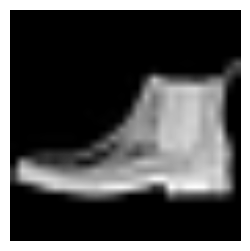

  -------------    
Label: T-shirt/top. Prévision: T-shirt/top.


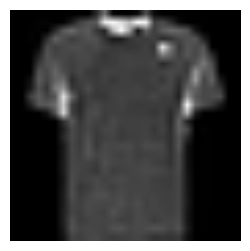

  -------------    
Label: Chemise. Prévision: Chemise.


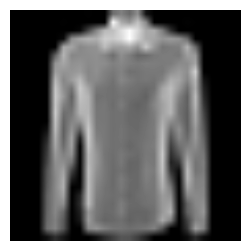

  -------------    
Label: Chemise. Prévision: Chemise.


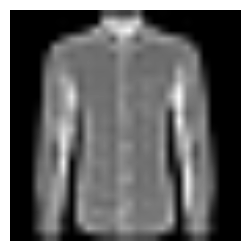

  -------------    
Label: T-shirt/top. Prévision: T-shirt/top.


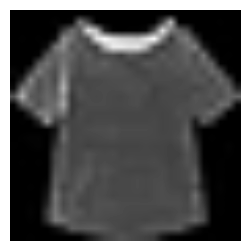

  -------------    
Label: Pantalon. Prévision: Pantalon.


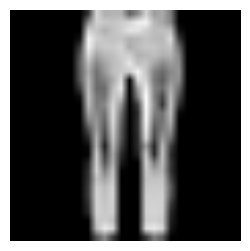

  -------------    
Label: Chemise. Prévision: Manteau.


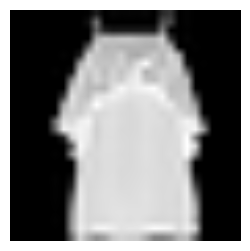

  -------------    
Label: Sac. Prévision: Sac.


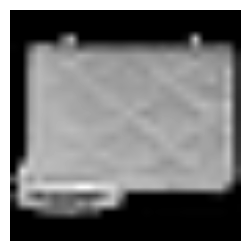

  -------------    
Label: T-shirt/top. Prévision: T-shirt/top.


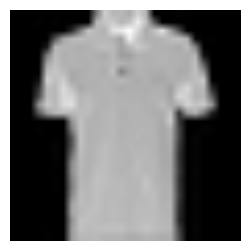

  -------------    
Label: Sandale. Prévision: Sandale.


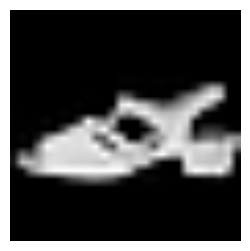

  -------------    
Label: Manteau. Prévision: Pull-over.


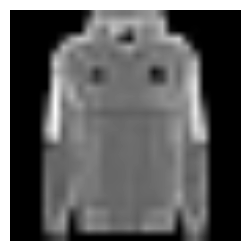

  -------------    
Label: Sac. Prévision: Sac.


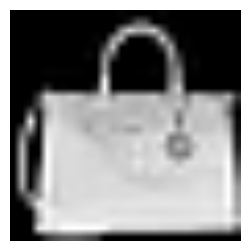

  -------------    
Label: Chemise. Prévision: Chemise.


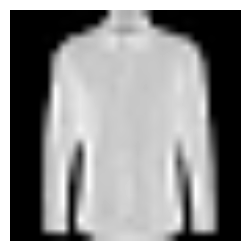

  -------------    
Label: T-shirt/top. Prévision: T-shirt/top.


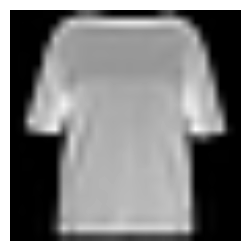

  -------------    
Label: Robe. Prévision: Robe.


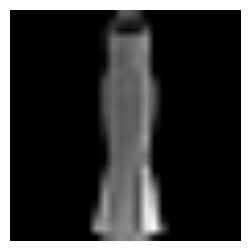

  -------------    
Label: Sandale. Prévision: Sandale.


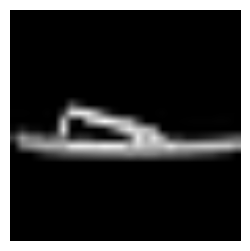

  -------------    
Label: Pantalon. Prévision: Pantalon.


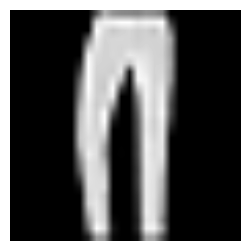

  -------------    
Label: Espadrilles. Prévision: Espadrilles.


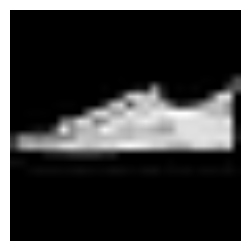

  -------------    
Label: Chemise. Prévision: Chemise.


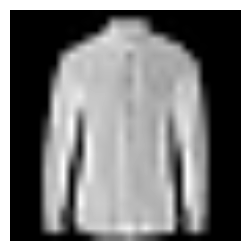

  -------------    
Label: Chemise. Prévision: Chemise.


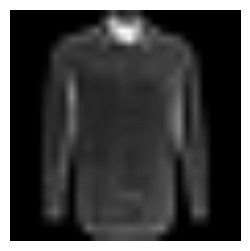

  -------------    


In [25]:
for i in range (10):
    pos = np.random.randint(1024)
    sample = example_datas[pos][0]
    fig = plt.figure(figsize=(3,3))
    plt.axis('off')
    plt.imshow(sample, cmap='gray', interpolation='bilinear')
    output = model(sample.unsqueeze(0).unsqueeze(0).to(device))
    print("Label: %s. Prévision: %s."%(
        libelle_label[labels[pos].item()],
        libelle_label[output.argmax(dim=1, keepdim=True).item()]
    ))
    plt.show()
    print("  -------------    ")

